In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# PREDICTING FUNCTION

In [2]:
# read data for experimentally determined structures in complex with active molecules
df = pd.read_csv('data/364_interaction_energies_state_function_v4.txt', sep='\t')

#drop index
df.drop('index', axis = 1, inplace=True)

#copy df to structure_df
structure_df = df.copy()
# structure_df.drop(['PDBID','State'], axis = 1, inplace = True)
structure_df.drop(['State'], axis = 1, inplace = True)

# add entry_type field to denote if entry is crystallized, docked, etc.
structure_df['entry_type'] = 'experimentally determined active'

In [3]:
# read data for best scoring docked poses of inactive molecules
df = pd.read_csv('data/dude_docking_data/dude_interaction_energies.txt', sep='\t')

#drop index
df.drop('index', axis = 1, inplace=True)

#copy df to dock_tructure_df
dock_structure_df = df.copy()
# dock_structure_df.drop(['PDBID','State'], axis = 1, inplace = True)
dock_structure_df.drop(['State'], axis = 1, inplace = True)

# add entry_type field
dock_structure_df['entry_type'] = 'docked inactive'

In [4]:
# read data for best scoring docked poses of inactive molecules
df1 = pd.read_csv('data/selfdock_docking_data/selfdock_interaction_energies.txt', sep='\t')

#drop index
df1.drop('index', axis = 1, inplace=True)

#copy df to dock_tructure_df
selfdock_structure_df = df1.copy()
# dock_structure_df.drop(['PDBID','State'], axis = 1, inplace = True)
selfdock_structure_df.drop(['State'], axis = 1, inplace = True)

# add entry_type field
selfdock_structure_df['entry_type'] = 'self-docked active'

In [5]:
# read data for best scoring docked poses of inactive molecules that weren't in the old test set
df2 = pd.read_csv('data/selfdock_docking_data/nontestset_selfdock_interaction_energies.txt', sep='\t')

#drop index
df2.drop('index', axis = 1, inplace=True)

#copy df to dock_tructure_df
nontestset_selfdock_structure_df = df2.copy()
# dock_structure_df.drop(['PDBID','State'], axis = 1, inplace = True)
nontestset_selfdock_structure_df.drop(['State'], axis = 1, inplace = True)

# add entry_type field
nontestset_selfdock_structure_df['entry_type'] = 'self-docked active'

In [6]:
# read data for best scoring docked poses of inactive molecules that weren't in the old test set
df3 = pd.read_csv('data/crossdock_docking_data/crossdock_interaction_energies.txt', sep=',')

#drop index
df3.drop('index', axis = 1, inplace=True)

#copy df to dock_tructure_df
crossdock_structure_df = df3.copy()
# dock_structure_df.drop(['PDBID','State'], axis = 1, inplace = True)
crossdock_structure_df.drop(['State'], axis = 1, inplace = True)

# add entry_type field
crossdock_structure_df['entry_type'] = 'cross-docked active'

In [7]:
print('ED structures:', len(structure_df))
print('DUD-E docked inactives:', len(dock_structure_df))
print('test set self docked actives:', len(selfdock_structure_df))
print('non-test set self docked actives:', len(nontestset_selfdock_structure_df))
print('cross docked actives:', len(crossdock_structure_df))
print('total structures:', len(structure_df) + len(dock_structure_df) + len(selfdock_structure_df) + len(nontestset_selfdock_structure_df) + len(crossdock_structure_df))

ED structures: 364
DUD-E docked inactives: 285
test set self docked actives: 105
non-test set self docked actives: 259
cross docked actives: 331
total structures: 1344


In [8]:
# join all datasets
frames = [structure_df, dock_structure_df, selfdock_structure_df, nontestset_selfdock_structure_df, crossdock_structure_df] 
structure_df = pd.concat(frames)

# reset index of structure_df
structure_df.reset_index(inplace = True, drop = True)

In [9]:
# drop entries with bad ligand placement
PDBs_toremove = [
    '4LDL',
    '4LDO',
    '7VDL',
    '7VDM',
    '7VUY',
    '7VUZ',
    '7VV0',
    '7VV3',
    '7VV4',
    '7VV5',
    '7NA7',
    '7FIG',
    '7FIH',
    '7P02',
    '7P00',
    '4U15',
    '2YCX',
    '6YVR',
    '5T04',
    '4XEE',
    '4XES',
    '4GRV'
]

to_drop = []

for i in range(len(structure_df)):
    if structure_df.iloc[i,:]['PDBID'] in PDBs_toremove:
        to_drop.append(i)

structure_df.drop(to_drop, inplace = True)

In [10]:
len(PDBs_toremove)

22

In [11]:
# get columns with 'sum' in their name
sum_cols = [col for col in structure_df.columns if 'sum' in col]

# create empty list for residue numbers
resnums = []

# loop through sum columns and count interactions that don't have nonzero energies
for col in sum_cols:
    resnum = col[:4]
    resnums.append(resnum)

# drop columns from df in which > 10% of entries are NaN
for resnum in resnums:
    intenergysum_col = resnum + '_intenergysum'
    inttype1_col = resnum + '_inttype1'
    intenergy1_col = resnum + '_intenergy1'
    inttype2_col = resnum + '_inttype2'
    intenergy2_col = resnum + '_intenergy2'
    
    print('structures with interactions at position', resnum, ':', structure_df[intenergysum_col][structure_df[intenergysum_col] != 0].value_counts().sum())
    if structure_df[intenergysum_col][structure_df[intenergysum_col] != 0].value_counts().sum() < 10:
        structure_df.drop([intenergysum_col, inttype1_col, intenergy1_col, inttype2_col, intenergy2_col], axis = 1, inplace = True)
        print('dropped columns for residue: ', resnum, '\n')

structures with interactions at position 1.21 : 0
dropped columns for residue:  1.21 

structures with interactions at position 1.22 : 0
dropped columns for residue:  1.22 

structures with interactions at position 1.23 : 0
dropped columns for residue:  1.23 

structures with interactions at position 1.24 : 0
dropped columns for residue:  1.24 

structures with interactions at position 1.25 : 0
dropped columns for residue:  1.25 

structures with interactions at position 1.26 : 0
dropped columns for residue:  1.26 

structures with interactions at position 1.27 : 4
dropped columns for residue:  1.27 

structures with interactions at position 1.28 : 4
dropped columns for residue:  1.28 

structures with interactions at position 1.29 : 0
dropped columns for residue:  1.29 

structures with interactions at position 1.30 : 6
dropped columns for residue:  1.30 

structures with interactions at position 1.31 : 21
structures with interactions at position 1.32 : 2
dropped columns for residue: 

structures with interactions at position 3.52 : 1
dropped columns for residue:  3.52 

structures with interactions at position 3.53 : 5
dropped columns for residue:  3.53 

structures with interactions at position 3.54 : 1
dropped columns for residue:  3.54 

structures with interactions at position 3.55 : 0
dropped columns for residue:  3.55 

structures with interactions at position 3.56 : 0
dropped columns for residue:  3.56 

structures with interactions at position 3.57 : 0
dropped columns for residue:  3.57 

structures with interactions at position 3.58 : 0
dropped columns for residue:  3.58 

structures with interactions at position 3.59 : 0
dropped columns for residue:  3.59 

structures with interactions at position 3.60 : 0
dropped columns for residue:  3.60 

structures with interactions at position 3.61 : 0
dropped columns for residue:  3.61 

structures with interactions at position 3.62 : 0
dropped columns for residue:  3.62 

structures with interactions at position 3.

structures with interactions at position 5.83 : 0
dropped columns for residue:  5.83 

structures with interactions at position 5.84 : 0
dropped columns for residue:  5.84 

structures with interactions at position 5.85 : 0
dropped columns for residue:  5.85 

structures with interactions at position 5.86 : 0
dropped columns for residue:  5.86 

structures with interactions at position 5.87 : 0
dropped columns for residue:  5.87 

structures with interactions at position 6.15 : 0
dropped columns for residue:  6.15 

structures with interactions at position 6.16 : 0
dropped columns for residue:  6.16 

structures with interactions at position 6.17 : 0
dropped columns for residue:  6.17 

structures with interactions at position 6.18 : 0
dropped columns for residue:  6.18 

structures with interactions at position 6.19 : 0
dropped columns for residue:  6.19 

structures with interactions at position 6.20 : 0
dropped columns for residue:  6.20 

structures with interactions at position 6.

In [12]:
structure_df

,PDBID,Function,1.31_intenergysum,1.31_inttype1,1.31_intenergy1,1.31_inttype2,1.31_intenergy2,1.35_intenergysum,1.35_inttype1,1.35_intenergy1,...,7.43_inttype1,7.43_intenergy1,7.43_inttype2,7.43_intenergy2,7.46_intenergysum,7.46_inttype1,7.46_intenergy1,7.46_inttype2,7.46_intenergy2,entry_type
0,7EW2,Agonist,NaN,NaN,NaN,NaN,NaN,0.0,None,0.0,...,None,0.0,None,0.0,0.0,None,0.0,None,0.0,experimentally determined active
1,7EW3,Agonist,NaN,NaN,NaN,NaN,NaN,0.0,None,0.0,...,None,0.0,None,0.0,0.0,None,0.0,None,0.0,experimentally determined active
2,7EW4,Agonist,NaN,NaN,NaN,NaN,NaN,0.0,None,0.0,...,None,0.0,None,0.0,0.0,None,0.0,None,0.0,experimentally determined active
3,7EW1,Agonist,NaN,NaN,NaN,NaN,NaN,0.0,None,0.0,...,None,0.0,None,0.0,0.0,None,0.0,None,0.0,experimentally determined active
4,7LD4,Agonist,0.0,None,0.0,None,0.0,0.0,None,0.0,...,Hbond,-0.5,Hbond,-0.1,0.0,None,0.0,None,0.0,experimentally determined active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,7VUG,Agonist,0.0,None,0.0,None,0.0,0.0,None,0.0,...,None,0.0,None,0.0,0.0,None,0.0,None,0.0,cross-docked active
1340,7VUG,Agonist,0.0,None,0.0,None,0.0,0.0,None,0.0,...,None,0.0,None,0.0,0.0,None,0.0,None,0.0,cross-docked active
1341,7VUG,Agonist,0.0,None,0.0,None,0.0,0.0,None,0.0,...,None,0.0,None,0.0,0.0,None,0.0,None,0.0,cross-docked active
1342,7S8L,Agonist,0.0,None,0.0,None,0.0,0.0,None,0.0,...,None,0.0,None,0.0,0.0,None,0.0,None,0.0,cross-docked active


In [13]:
uniq_residues = []
cols = list(structure_df.columns[2:])

for col in cols:
    res = col[:4]
    if res not in uniq_residues:
        uniq_residues.append(res)
        
print('residues used as predictors:', uniq_residues)

residues used as predictors: ['1.31', '1.35', '1.39', '1.42', '2.53', '2.54', '2.56', '2.57', '2.58', '2.60', '2.61', '2.63', '2.64', '2.65', '3.25', '3.26', '3.28', '3.29', '3.30', '3.32', '3.33', '3.35', '3.36', '3.37', '3.40', '4.56', '4.57', '4.60', '5.31', '5.35', '5.38', '5.39', '5.40', '5.41', '5.42', '5.43', '5.46', '5.47', '6.48', '6.51', '6.52', '6.54', '6.55', '6.58', '6.59', '7.31', '7.32', '7.34', '7.35', '7.36', '7.38', '7.39', '7.40', '7.42', '7.43', '7.46', 'entr']


In [14]:
cols

['1.31_intenergysum',
 '1.31_inttype1',
 '1.31_intenergy1',
 '1.31_inttype2',
 '1.31_intenergy2',
 '1.35_intenergysum',
 '1.35_inttype1',
 '1.35_intenergy1',
 '1.35_inttype2',
 '1.35_intenergy2',
 '1.39_intenergysum',
 '1.39_inttype1',
 '1.39_intenergy1',
 '1.39_inttype2',
 '1.39_intenergy2',
 '1.42_intenergysum',
 '1.42_inttype1',
 '1.42_intenergy1',
 '1.42_inttype2',
 '1.42_intenergy2',
 '2.53_intenergysum',
 '2.53_inttype1',
 '2.53_intenergy1',
 '2.53_inttype2',
 '2.53_intenergy2',
 '2.54_intenergysum',
 '2.54_inttype1',
 '2.54_intenergy1',
 '2.54_inttype2',
 '2.54_intenergy2',
 '2.56_intenergysum',
 '2.56_inttype1',
 '2.56_intenergy1',
 '2.56_inttype2',
 '2.56_intenergy2',
 '2.57_intenergysum',
 '2.57_inttype1',
 '2.57_intenergy1',
 '2.57_inttype2',
 '2.57_intenergy2',
 '2.58_intenergysum',
 '2.58_inttype1',
 '2.58_intenergy1',
 '2.58_inttype2',
 '2.58_intenergy2',
 '2.60_intenergysum',
 '2.60_inttype1',
 '2.60_intenergy1',
 '2.60_inttype2',
 '2.60_intenergy2',
 '2.61_intenergysum'

<AxesSubplot:>

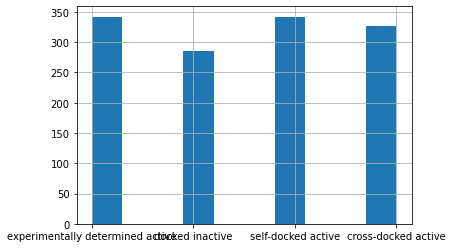

In [15]:
# plot displaying number of each entry type
structure_df['entry_type'].hist()

In [16]:
structure_df['Function'].value_counts()

Antagonist           532
Agonist              372
Inactive             285
Inverse agonist       73
Agonist (partial)     33
Name: Function, dtype: int64

In [17]:
structure_df['entry_type'].value_counts().sort_index()

cross-docked active                 326
docked inactive                     285
experimentally determined active    342
self-docked active                  342
Name: entry_type, dtype: int64

In [18]:
structure_df['entry_type'].value_counts().sum() # number of entries in the dataset

1295

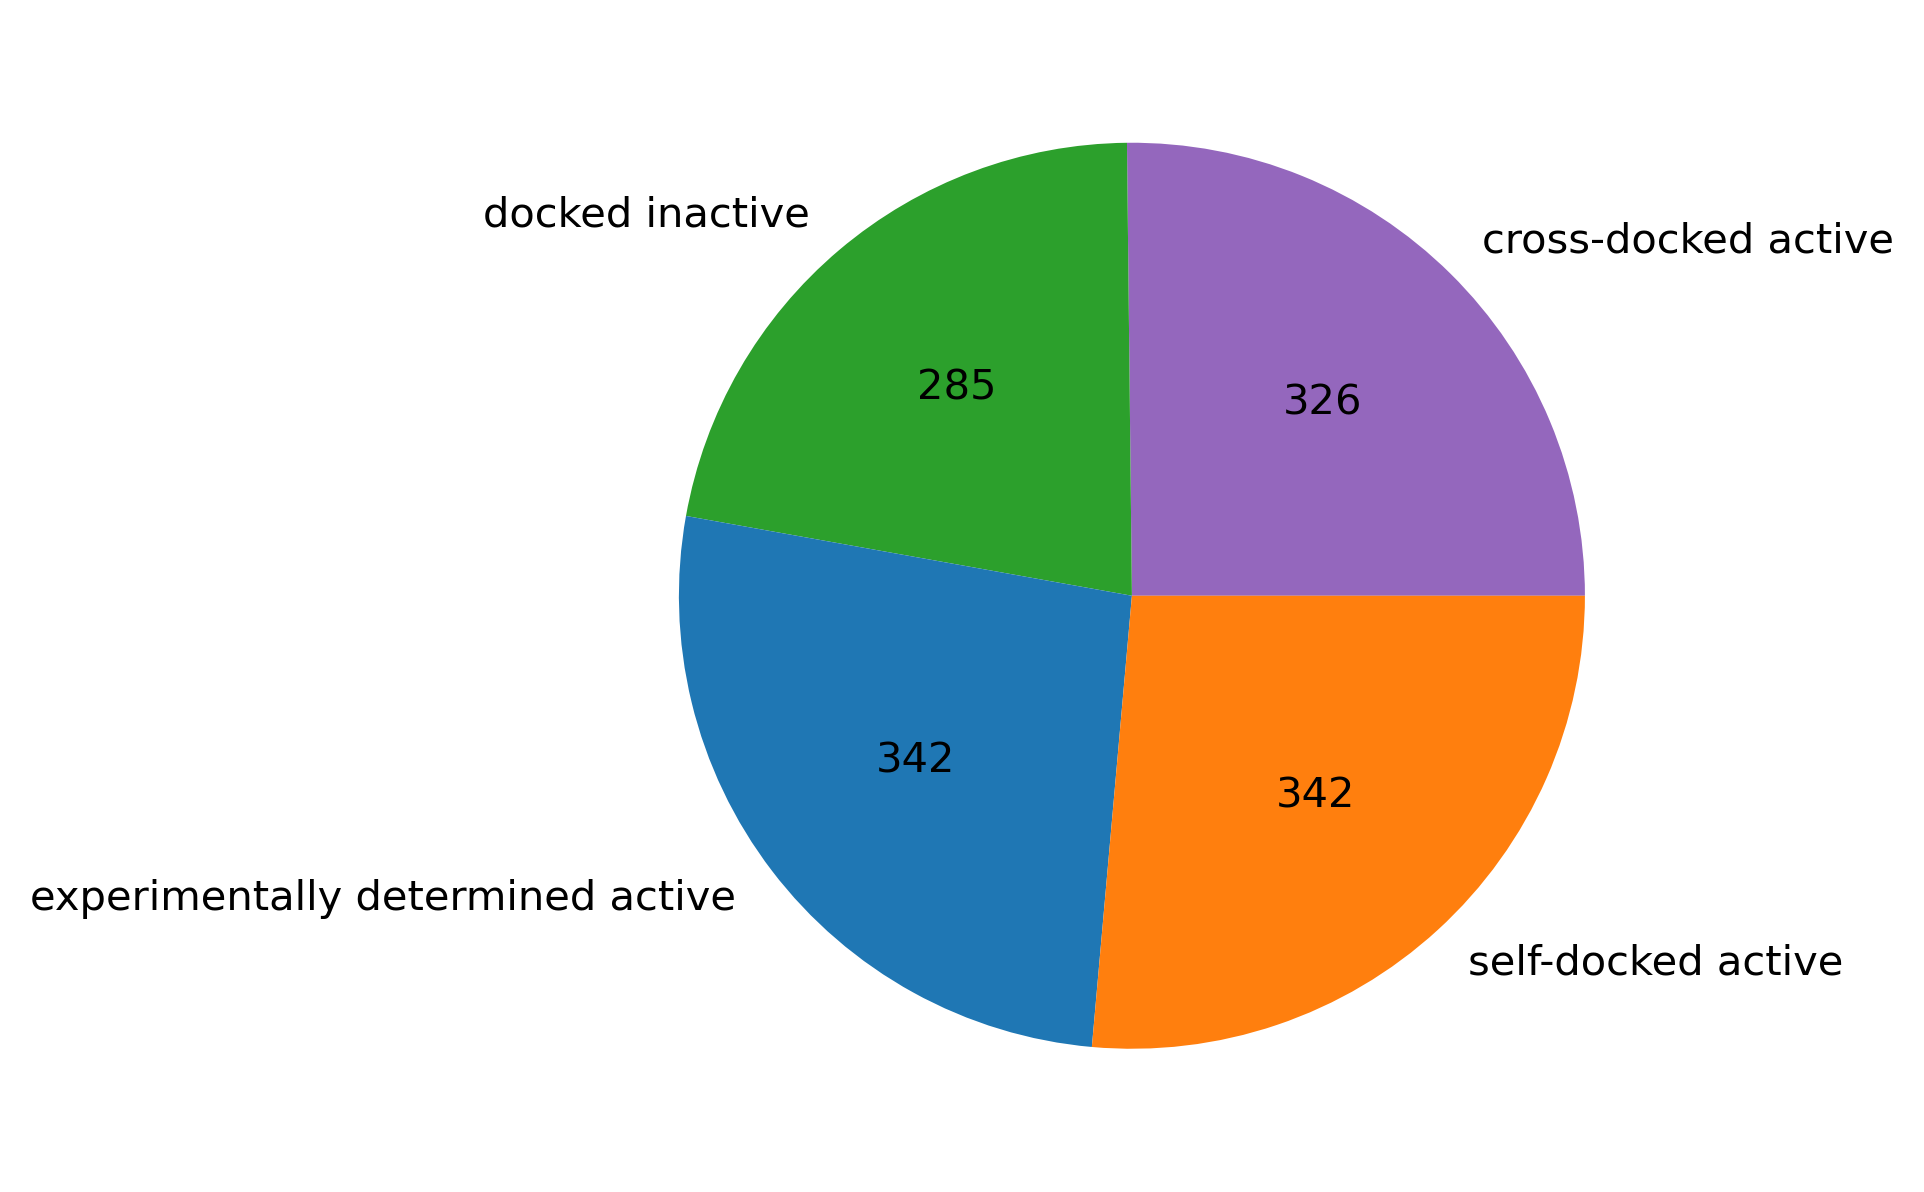

In [19]:
# pie chart

# color key
colors = {'experimentally determined active': 'tab:blue',
           'self-docked active': 'tab:orange',
            'cross-docked active': 'tab:purple',
             'docked inactive': 'tab:green',}

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams['figure.dpi'] = 300

values=structure_df['entry_type'].value_counts(dropna=True).sort_index()
vc = structure_df['entry_type'].value_counts(dropna=True).sort_index()
labels = vc.index

plt.pie(list(structure_df['entry_type'].value_counts().sort_index()),
        labels = labels,
        autopct= lambda x: '{:.0f}'.format(x*values.sum()/100),
        colors = [colors[key] for key in labels]
       )
plt.show() 

In [20]:
# drop entry_type field but save it for later
entry_types = structure_df['entry_type']
structure_df.drop(['entry_type'], axis = 1, inplace = True)

In [21]:
# simplification: replace partial agonist with agonist
structure_df = structure_df.replace('Agonist (partial)', 'Agonist')

In [22]:
actual_fxns = structure_df['Function']

In [23]:
actual_fxns.unique()

array(['Agonist', 'Antagonist', 'Inverse agonist', 'Inactive'],
      dtype=object)

## Label Encoding

In [24]:
# convert inttype columns to string and get unique interaction types
interaction_types = []
inttype_cols = [col for col in structure_df.columns if 'inttype' in col]

for col in inttype_cols:
    structure_df[col] = structure_df[col].astype(str)
    uniq_col_ints = list(structure_df[col].unique())
    for interaction in uniq_col_ints:
        if interaction not in interaction_types:
            interaction_types.append(interaction)

In [25]:
interaction_types

['nan', 'None', 'Hbond', 'Distance', 'Arene', 'Ionic', 'Covalent']

In [26]:
# custom encoding for inttypes
custom_mapping = {'nan' : 0, 'None' : 1, 'Hbond' : 2, 'Distance' : 3, 'Arene' : 4, 'Ionic' : 5, 'Covalent' : 6}

for col in inttype_cols:
    structure_df[col] = structure_df[col].map(custom_mapping)
    
# LabelEncoder for Function labels
le = LabelEncoder()

# get Function columns
cols = [col for col in structure_df.columns if 'Function' in col]

# loop though all columns and convert strings to categorical integer variable
for col in cols:
    structure_df[col] = le.fit_transform(structure_df[col])

In [27]:
structure_df

,PDBID,Function,1.31_intenergysum,1.31_inttype1,1.31_intenergy1,1.31_inttype2,1.31_intenergy2,1.35_intenergysum,1.35_inttype1,1.35_intenergy1,...,7.43_intenergysum,7.43_inttype1,7.43_intenergy1,7.43_inttype2,7.43_intenergy2,7.46_intenergysum,7.46_inttype1,7.46_intenergy1,7.46_inttype2,7.46_intenergy2
0,7EW2,0,NaN,0,NaN,0,NaN,0.0,1,0.0,...,0.0,1,0.0,1,0.0,0.0,1,0.0,1,0.0
1,7EW3,0,NaN,0,NaN,0,NaN,0.0,1,0.0,...,0.0,1,0.0,1,0.0,0.0,1,0.0,1,0.0
2,7EW4,0,NaN,0,NaN,0,NaN,0.0,1,0.0,...,0.0,1,0.0,1,0.0,0.0,1,0.0,1,0.0
3,7EW1,0,NaN,0,NaN,0,NaN,0.0,1,0.0,...,0.0,1,0.0,1,0.0,0.0,1,0.0,1,0.0
4,7LD4,0,0.0,1,0.0,1,0.0,0.0,1,0.0,...,-0.6,2,-0.5,2,-0.1,0.0,1,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,7VUG,0,0.0,1,0.0,1,0.0,0.0,1,0.0,...,0.0,1,0.0,1,0.0,0.0,1,0.0,1,0.0
1340,7VUG,0,0.0,1,0.0,1,0.0,0.0,1,0.0,...,0.0,1,0.0,1,0.0,0.0,1,0.0,1,0.0
1341,7VUG,0,0.0,1,0.0,1,0.0,0.0,1,0.0,...,0.0,1,0.0,1,0.0,0.0,1,0.0,1,0.0
1342,7S8L,0,0.0,1,0.0,1,0.0,0.0,1,0.0,...,0.0,1,0.0,1,0.0,0.0,1,0.0,1,0.0


In [28]:
le.classes_

array(['Agonist', 'Antagonist', 'Inactive', 'Inverse agonist'],
      dtype=object)

In [29]:
# assign target classes to y
y = structure_df['Function']

# assign data to X
X = structure_df.drop(['Function'], axis = 1)

# create actual_state column with non-encoded states
X['actual_fxn'] = actual_fxns

In [30]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

## Scaling/Imputing

In [31]:
def scale_impute(dataframe):
    # get colnames
    colnames = list(dataframe.drop(['actual_fxn', 'PDBID'], axis = 1).columns)
    fxns_df = dataframe['actual_fxn']
    #state_df.reset_index(inplace=True)
    df = dataframe.drop(['actual_fxn'], axis = 1)
    PDBIDs = list(dataframe['PDBID'])

    # impute data
    from sklearn.impute import SimpleImputer
    my_imputer = SimpleImputer()
    df_imputed = pd.DataFrame(my_imputer.fit_transform(df.iloc[:,1:]))

    # scale data
    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    to_scale = [col for col in df_imputed.columns.values]
    scaler.fit(df_imputed[to_scale])

    # predict z-scores on the test set
    df_imputed[to_scale] = scaler.transform(df_imputed[to_scale]) 

    # #rename columns
    df_imputed.columns = colnames
    
    df_imputed.insert(0, 'PDBID',  PDBIDs)

    # display scaled values
    display(df_imputed)
    
    return(df_imputed, fxns_df)

In [32]:
(X_train_imputed, X_train_fxns) = scale_impute(X_train)
(X_test_imputed, X_test_fxns) = scale_impute(X_test)

,PDBID,1.31_intenergysum,1.31_inttype1,1.31_intenergy1,1.31_inttype2,1.31_intenergy2,1.35_intenergysum,1.35_inttype1,1.35_intenergy1,1.35_inttype2,...,7.43_intenergysum,7.43_inttype1,7.43_intenergy1,7.43_inttype2,7.43_intenergy2,7.46_intenergysum,7.46_inttype1,7.46_intenergy1,7.46_inttype2,7.46_intenergy2
0,7E2Y,3.128547e-17,-0.978137,-5.549546e-17,-0.959821,0.000000,8.690069e-02,-0.199360,8.460177e-02,-0.121502,...,0.063977,1.667607,0.042421,0.807957,0.080826,0.08228,-0.163404,0.076444,-0.157525,0.033067
1,3NY8,3.128547e-17,-0.978137,-5.549546e-17,-0.959821,0.000000,8.690069e-02,-0.199360,8.460177e-02,-0.121502,...,0.132117,0.696253,0.142886,0.807957,0.080826,0.08228,-0.163404,0.076444,-0.157525,0.033067
2,7WF7,3.128547e-17,-0.978137,-5.549546e-17,-0.959821,0.000000,8.690069e-02,-0.199360,8.460177e-02,-0.121502,...,0.132117,-1.246454,0.142886,-1.185757,0.080826,0.08228,-0.163404,0.076444,-0.157525,0.033067
3,3PBL,3.128547e-17,-0.978137,-5.549546e-17,-0.959821,0.000000,9.788194e-18,-1.959163,-1.072041e-17,-2.228264,...,0.132117,0.696253,0.142886,0.807957,0.080826,0.08228,-0.163404,0.076444,-0.157525,0.033067
4,3EML,3.128547e-17,-0.978137,-5.549546e-17,-0.959821,0.000000,8.690069e-02,3.320247,8.460177e-02,4.092021,...,0.132117,-1.246454,0.142886,-1.185757,0.080826,0.08228,-0.163404,0.076444,-0.157525,0.033067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,7DH5,3.128547e-17,-0.978137,-5.549546e-17,-0.959821,0.000000,8.690069e-02,-0.199360,8.460177e-02,-0.121502,...,0.132117,0.696253,0.142886,-1.185757,0.080826,0.08228,-0.163404,0.076444,-0.157525,0.033067
967,6TP6,3.128547e-17,-0.978137,-5.549546e-17,-0.959821,0.000000,8.690069e-02,-0.199360,8.460177e-02,-0.121502,...,0.132117,0.696253,0.142886,0.807957,0.080826,0.08228,-0.163404,0.076444,-0.157525,0.033067
968,5WIU,3.128547e-17,-0.978137,-5.549546e-17,-0.959821,0.000000,8.690069e-02,-0.199360,8.460177e-02,-0.121502,...,0.132117,0.696253,0.142886,0.807957,0.080826,0.08228,-0.163404,0.076444,-0.157525,0.033067
969,4PY0,1.657197e-01,0.656581,1.544339e-01,0.644286,0.128212,8.690069e-02,-0.199360,8.460177e-02,-0.121502,...,0.132117,-1.246454,0.142886,-1.185757,0.080826,0.08228,-0.163404,0.076444,-0.157525,0.033067


,PDBID,1.31_intenergysum,1.31_inttype1,1.31_intenergy1,1.31_inttype2,1.31_intenergy2,1.35_intenergysum,1.35_inttype1,1.35_intenergy1,1.35_inttype2,...,7.43_intenergysum,7.43_inttype1,7.43_intenergy1,7.43_inttype2,7.43_intenergy2,7.46_intenergysum,7.46_inttype1,7.46_intenergy1,7.46_inttype2,7.46_intenergy2
0,5D5A,0.243829,0.568420,0.241197,0.455931,0.185575,0.174273,-0.192788,0.185933,-0.115249,...,0.213774,0.642753,0.184985,0.835398,0.158122,0.085303,-0.176608,0.066909,-0.154341,0.058014
1,6ZFZ,0.243829,0.568420,0.241197,0.455931,0.185575,0.174273,-0.192788,0.185933,-0.115249,...,-0.689654,1.576618,-0.756404,0.835398,0.158122,0.085303,-0.176608,0.066909,-0.154341,0.058014
2,6VMS,0.000000,-0.966315,0.000000,-0.851340,0.000000,0.174273,-0.192788,0.185933,-0.115249,...,-0.388511,1.576618,-0.442608,0.835398,0.158122,0.085303,-0.176608,0.066909,-0.154341,0.058014
3,7DHR,0.243829,0.568420,0.241197,0.455931,0.185575,0.174273,-0.192788,0.185933,-0.115249,...,0.213774,0.642753,0.184985,0.835398,0.158122,0.085303,-0.176608,0.066909,-0.154341,0.058014
4,6H7N,0.000000,-0.966315,0.000000,-0.851340,0.000000,0.174273,-0.192788,0.185933,-0.115249,...,0.213774,0.642753,0.184985,0.835398,0.158122,0.085303,-0.176608,0.066909,-0.154341,0.058014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,5NM4,0.243829,0.568420,0.241197,0.455931,0.185575,0.174273,-0.192788,0.185933,-0.115249,...,0.213774,0.642753,0.184985,0.835398,0.158122,0.085303,-0.176608,0.066909,-0.154341,0.058014
320,3ODU,0.243829,0.568420,0.241197,0.455931,0.185575,-2.265554,1.408838,-3.904592,-0.115249,...,0.213774,-1.224977,0.184985,-1.125971,0.158122,0.085303,-0.176608,0.066909,-0.154341,0.058014
321,6PS3,0.243829,0.568420,0.241197,0.455931,0.185575,0.174273,-0.192788,0.185933,-0.115249,...,0.213774,0.642753,0.184985,-1.125971,0.158122,0.085303,-0.176608,0.066909,-0.154341,0.058014
322,7VOE,0.000000,-0.966315,0.000000,-0.851340,0.000000,0.174273,-0.192788,0.185933,-0.115249,...,0.213774,-1.224977,0.184985,-1.125971,0.158122,0.085303,-0.176608,0.066909,-0.154341,0.058014


<AxesSubplot:>

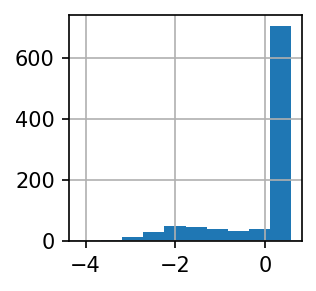

In [33]:
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['figure.dpi'] = 150
X_train_imputed['3.32_intenergysum'].hist()

In [34]:
X_train_fxns = X_train_fxns.reset_index()
X_train_fxns.drop(['index'], axis = 1, inplace = True)

X_test_fxns = X_test_fxns.reset_index()
X_test_fxns.drop(['index'], axis = 1, inplace = True)

In [35]:
def train_test_predict(train_df, train_y, test_df, test_y, encoder):
    #Import Random Forest Model
    from sklearn.ensemble import RandomForestClassifier

    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=1000, random_state=1, class_weight = 'balanced_subsample')

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(train_df.iloc[:, 1:], train_y)
    
    # print classes able to be predicted by the model (check 8/1/22)
    # print(clf.classes_)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score, KFold
    import numpy as np

    # cross-validation
    scores = cross_val_score(clf, train_df.iloc[:, 1:], train_y, cv=5)
    print("Mean cross-validation score: %.2f" % scores.mean())

    # k-fold CV
    kfold = KFold(n_splits=10, shuffle=True, random_state = 1)
    kf_cv_scores = cross_val_score(clf, train_df.iloc[:, 1:], train_y, cv=kfold)
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
    
    # test set predictions
    y_pred = clf.predict(test_df.iloc[:, 1:])
    
    # print unique classes predicted on the testing data (check 8/1/22)
    # print(np.unique(y_pred))

    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics

    # reverse label encoding
    y_pred_actual = encoder.inverse_transform(y_pred)
    y_test_actual = encoder.inverse_transform(test_y)

    data = {'y_Actual':    y_test_actual,
            'y_Predicted': y_pred_actual
            }

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    print ('\n', confusion_matrix, '\n')
    
     # Model Accuracy, how often is the classifier correct?
    acc = metrics.accuracy_score(test_y, y_pred)
    precision = metrics.precision_score(test_y, y_pred, average = 'weighted', labels=np.unique(y_pred))
    recall = metrics.recall_score(test_y, y_pred, average = 'weighted', labels=np.unique(y_pred))
    print("Accuracy:","{:.2f}".format(acc))
    print("Precision:","{:.2f}".format(precision))
    print("Recall:","{:.2f}".format(recall), '\n')
    return y_pred_actual, y_test_actual, clf

In [36]:
y_pred_actual, y_test_actual, rf_model = train_test_predict(X_train_imputed, y_train, X_test_imputed, y_test, le)

Mean cross-validation score: 0.86
K-fold CV average score: 0.87

 Predicted        Agonist  Antagonist  Inactive  Inverse agonist
Actual                                                         
Agonist               84          14         0                0
Antagonist            10         122         2                2
Inactive               6           1        60                0
Inverse agonist        3           9         0               11 

Accuracy: 0.85
Precision: 0.86
Recall: 0.85 



# HM DOCKING DATA CLASSIFICATION

In [37]:
gpr31_df = pd.read_csv('data/hm_docking_data/gpr31_interaction_energies.txt')
gpr31_df = gpr31_df.rename(columns={'Target': 'PDBID'})

In [38]:
taar2_df = pd.read_csv('data/hm_docking_data/taar2_interaction_energies.txt')
taar2_df = taar2_df.rename(columns={'Target': 'PDBID'})

In [39]:
# join all datasets
frames = [gpr31_df, taar2_df] 
ext_df = pd.concat(frames)

# reset index of structure_df
ext_df.reset_index(inplace = True, drop = True)

In [40]:
len(structure_df.columns)

282

In [41]:
ext_df

,index,PDBID,Name,Function,1.21_intenergysum,1.21_inttype1,1.21_intenergy1,1.21_inttype2,1.21_intenergy2,1.22_intenergysum,...,7.67_intenergysum,7.67_inttype1,7.67_intenergy1,7.67_inttype2,7.67_intenergy2,7.68_intenergysum,7.68_inttype1,7.68_intenergy1,7.68_inttype2,7.68_intenergy2
0,1,GPR31,12S-hydroxy-5E 8Z 10Z 14Z-eicosatetraenoic acid,Agonist,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,GPR31,5(S)-Hete,Agonist,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,GPR31,15(S)-Hete,Agonist,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,GPR31,LTB4,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,GPR31,PGA1,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,GPR31,PGE2,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,GPR31,PGB1,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,GPR31,PGB2,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,GPR31,PGF2a,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,GPR31,12S-hydroxy-5E 8Z 10Z 14Z-eicosatetraenoic acid,Agonist,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
actual_fxns_ext = ext_df['Function']

In [43]:
# match columns to structure_df
for col in ext_df.columns:
    if col not in structure_df.columns and col != 'Target':
        ext_df.drop(col, axis = 1, inplace = True)

In [44]:
len(ext_df.columns)

282

In [45]:
# label encoding
def encode_labels_ext(df):
    cols = [col for col in df.columns if 'inttype' in col]

    # loop though all columns and convert strings to categorical integer variables using encoder for OG data
    for col in cols:
        # convert column values to string type 
        df[col] = df[col].astype(str)
         
        # map inttype columns using custom mapping
        df[col] = df[col].map(custom_mapping)
        


    # encode states as integers
    # get columns with 'type' in their name
    cols = [col for col in df.columns if 'Function' in col]

    # loop though all columns and convert strings to categorical integer variables using label encoder for OG data
    for col in cols:
        df[col] = le.transform(df[col])
        
    return df

In [46]:
ext_df_encoded = encode_labels_ext(ext_df)

In [47]:
le.classes_

array(['Agonist', 'Antagonist', 'Inactive', 'Inverse agonist'],
      dtype=object)

In [48]:
ext_df_encoded

,PDBID,Function,1.31_intenergysum,1.31_inttype1,1.31_intenergy1,1.31_inttype2,1.31_intenergy2,1.35_intenergysum,1.35_inttype1,1.35_intenergy1,...,7.43_intenergysum,7.43_inttype1,7.43_intenergy1,7.43_inttype2,7.43_intenergy2,7.46_intenergysum,7.46_inttype1,7.46_intenergy1,7.46_inttype2,7.46_intenergy2
0,GPR31,0,0,1,0,1,0,0.0,1,0.0,...,0.0,3,0.0,3,0,0,1,0,1,0
1,GPR31,0,0,1,0,1,0,0.0,1,0.0,...,-0.2,4,-0.2,3,0,0,1,0,1,0
2,GPR31,0,0,1,0,1,0,0.0,1,0.0,...,0.0,3,0.0,3,0,0,1,0,1,0
3,GPR31,2,0,1,0,1,0,0.0,3,0.0,...,-1.6,2,-1.6,3,0,0,1,0,1,0
4,GPR31,2,0,1,0,1,0,0.0,1,0.0,...,0.0,3,0.0,3,0,0,1,0,1,0
5,GPR31,2,0,1,0,1,0,0.0,1,0.0,...,0.0,3,0.0,3,0,0,1,0,1,0
6,GPR31,2,0,1,0,1,0,0.0,1,0.0,...,0.0,3,0.0,3,0,0,1,0,1,0
7,GPR31,2,0,1,0,1,0,0.0,1,0.0,...,-0.4,2,-0.4,3,0,0,1,0,1,0
8,GPR31,2,0,1,0,1,0,0.0,1,0.0,...,-0.9,2,-0.9,3,0,0,1,0,1,0
9,GPR31,0,0,1,0,1,0,0.0,1,0.0,...,0.0,1,0.0,1,0,0,1,0,1,0


In [49]:
# assign target classes to y
y_ext = ext_df['Function']

# assign data to X
X_ext = ext_df.drop(['Function'], axis = 1)

# create actual_state column with non-encoded states
X_ext['actual_fxn'] = actual_fxns_ext

In [50]:
(X_ext_imputed, X_ext_fxns) = scale_impute(X_ext)

,PDBID,1.31_intenergysum,1.31_inttype1,1.31_intenergy1,1.31_inttype2,1.31_intenergy2,1.35_intenergysum,1.35_inttype1,1.35_intenergy1,1.35_inttype2,...,7.43_intenergysum,7.43_inttype1,7.43_intenergy1,7.43_inttype2,7.43_intenergy2,7.46_intenergysum,7.46_inttype1,7.46_intenergy1,7.46_inttype2,7.46_intenergy2
0,GPR31,0.0,0.0,0.0,0.0,0.0,0.156174,-0.357718,0.156174,-0.324443,...,0.334778,0.762001,0.334778,1.100239,0.0,0.0,-0.156174,0.0,-0.156174,0.0
1,GPR31,0.0,0.0,0.0,0.0,0.0,0.156174,-0.357718,0.156174,-0.324443,...,-0.368256,1.651002,-0.368256,1.100239,0.0,0.0,-0.156174,0.0,-0.156174,0.0
2,GPR31,0.0,0.0,0.0,0.0,0.0,0.156174,-0.357718,0.156174,-0.324443,...,0.334778,0.762001,0.334778,1.100239,0.0,0.0,-0.156174,0.0,-0.156174,0.0
3,GPR31,0.0,0.0,0.0,0.0,0.0,0.156174,2.980982,0.156174,-0.324443,...,-5.289490,-0.127000,-5.289490,1.100239,0.0,0.0,-0.156174,0.0,-0.156174,0.0
4,GPR31,0.0,0.0,0.0,0.0,0.0,0.156174,-0.357718,0.156174,-0.324443,...,0.334778,0.762001,0.334778,1.100239,0.0,0.0,-0.156174,0.0,-0.156174,0.0
5,GPR31,0.0,0.0,0.0,0.0,0.0,0.156174,-0.357718,0.156174,-0.324443,...,0.334778,0.762001,0.334778,1.100239,0.0,0.0,-0.156174,0.0,-0.156174,0.0
6,GPR31,0.0,0.0,0.0,0.0,0.0,0.156174,-0.357718,0.156174,-0.324443,...,0.334778,0.762001,0.334778,1.100239,0.0,0.0,-0.156174,0.0,-0.156174,0.0
7,GPR31,0.0,0.0,0.0,0.0,0.0,0.156174,-0.357718,0.156174,-0.324443,...,-1.071289,-0.127000,-1.071289,1.100239,0.0,0.0,-0.156174,0.0,-0.156174,0.0
8,GPR31,0.0,0.0,0.0,0.0,0.0,0.156174,-0.357718,0.156174,-0.324443,...,-2.828873,-0.127000,-2.828873,1.100239,0.0,0.0,-0.156174,0.0,-0.156174,0.0
9,GPR31,0.0,0.0,0.0,0.0,0.0,0.156174,-0.357718,0.156174,-0.324443,...,0.334778,-1.016001,0.334778,-0.908893,0.0,0.0,-0.156174,0.0,-0.156174,0.0


In [51]:
y_ext_pred = rf_model.predict(X_ext_imputed.iloc[:, 1:])

In [52]:
le.classes_

array(['Agonist', 'Antagonist', 'Inactive', 'Inverse agonist'],
      dtype=object)

In [53]:
y_ext_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2])

In [54]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# reverse label encoding
y_ext_pred_actual = le.inverse_transform(y_ext_pred)
y_ext_actual = le.inverse_transform(y_ext)

data = {'y_Actual':    y_ext_actual,
        'y_Predicted': y_ext_pred_actual
        }

pred_df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(pred_df['y_Actual'], pred_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print ('\n', confusion_matrix, '\n')

 # Model Accuracy, how often is the classifier correct?
acc = metrics.accuracy_score(y_ext, y_ext_pred)
precision = metrics.precision_score(y_ext, y_ext_pred, average = 'weighted', labels=np.unique(y_ext_pred))
recall = metrics.recall_score(y_ext, y_ext_pred, average = 'weighted', labels=np.unique(y_ext_pred))
print("Accuracy:","{:.2f}".format(acc))
print("Precision:","{:.2f}".format(precision))
print("Recall:","{:.2f}".format(recall), '\n')


 Predicted  Agonist  Antagonist  Inactive
Actual                                  
Agonist         12           0         6
Inactive        23           1         0 

Accuracy: 0.29
Precision: 0.15
Recall: 0.29 



C:\Users\Greg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
pd.Series(y_ext_pred_actual)

0        Agonist
1        Agonist
2        Agonist
3        Agonist
4        Agonist
5     Antagonist
6        Agonist
7        Agonist
8        Agonist
9        Agonist
10       Agonist
11       Agonist
12       Agonist
13       Agonist
14       Agonist
15       Agonist
16       Agonist
17       Agonist
18       Agonist
19       Agonist
20       Agonist
21       Agonist
22       Agonist
23       Agonist
24       Agonist
25       Agonist
26       Agonist
27       Agonist
28       Agonist
29       Agonist
30       Agonist
31       Agonist
32       Agonist
33       Agonist
34       Agonist
35       Agonist
36      Inactive
37      Inactive
38      Inactive
39      Inactive
40      Inactive
41      Inactive
dtype: object

In [57]:
pd.Series(y_ext_actual)

0      Agonist
1      Agonist
2      Agonist
3     Inactive
4     Inactive
5     Inactive
6     Inactive
7     Inactive
8     Inactive
9      Agonist
10     Agonist
11     Agonist
12    Inactive
13    Inactive
14    Inactive
15    Inactive
16    Inactive
17    Inactive
18     Agonist
19     Agonist
20     Agonist
21    Inactive
22    Inactive
23    Inactive
24    Inactive
25    Inactive
26    Inactive
27     Agonist
28     Agonist
29     Agonist
30    Inactive
31    Inactive
32    Inactive
33    Inactive
34    Inactive
35    Inactive
36     Agonist
37     Agonist
38     Agonist
39     Agonist
40     Agonist
41     Agonist
dtype: object

In [58]:
pd.DataFrame({'Actual' : pd.Series(y_ext_actual), 'Predicted' : pd.Series(y_ext_pred_actual)})

,Actual,Predicted
0,Agonist,Agonist
1,Agonist,Agonist
2,Agonist,Agonist
3,Inactive,Agonist
4,Inactive,Agonist
5,Inactive,Antagonist
6,Inactive,Agonist
7,Inactive,Agonist
8,Inactive,Agonist
9,Agonist,Agonist
